# 示例：剩余使用寿命预测

In [1]:
from rulframework.data.feature.RMSFeatureExtractor import RMSFeatureExtractor
from rulframework.data.raw.XJTUDataLoader import XJTUDataLoader
from rulframework.data.dataset.RelativeRULGenerator import RelativeRULGenerator
from rulframework.model.PytorchModel import PytorchModel
from rulframework.model.cnn.CnnRul import CnnRul
from rulframework.data.stage.BearingStageCalculator import BearingStageCalculator
from rulframework.data.stage.eol.NinetyThreePercentRMSEoLCalculator import NinetyThreePercentRMSEoLCalculator
from rulframework.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from rulframework.predict.evaluator.End2EndEvaluator import End2EndEvaluator
from rulframework.predict.evaluator.end2end_metric.End2EndMAE import End2EndMAE
from rulframework.predict.evaluator.end2end_metric.End2EndMSE import End2EndMSE
from rulframework.predict.evaluator.end2end_metric.End2EndRMSE import End2EndRMSE
from rulframework.util.Plotter import Plotter

# 定义 数据加载器、特征提取器、fpt计算器、eol计算器

In [2]:
data_loader = XJTUDataLoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = RMSFeatureExtractor(32768)
fpt_calculator = ThreeSigmaFPTCalculator()
eol_calculator = NinetyThreePercentRMSEoLCalculator()
stage_calculator = BearingStageCalculator(fpt_calculator, eol_calculator, 32768)

INFO - 17:08:47 >> 
     █████╗ ███╗   ██╗██████╗ ██████╗ ███████╗██╗    ██╗    ███████╗████████╗██╗   ██╗██████╗ ██╗ ██████╗ 
     ██╔══██╗████╗  ██║██╔══██╗██╔══██╗██╔════╝██║    ██║    ██╔════╝╚══██╔══╝██║   ██║██╔══██╗██║██╔═══██╗
     ███████║██╔██╗ ██║██║  ██║██████╔╝█████╗  ██║ █╗ ██║    ███████╗   ██║   ██║   ██║██║  ██║██║██║   ██║
     ██╔══██║██║╚██╗██║██║  ██║██╔══██╗██╔══╝  ██║███╗██║    ╚════██║   ██║   ██║   ██║██║  ██║██║██║   ██║
     ██║  ██║██║ ╚████║██████╔╝██║  ██║███████╗╚███╔███╔╝    ███████║   ██║   ╚██████╔╝██████╔╝██║╚██████╔╝
     ╚═╝  ╚═╝╚═╝  ╚═══╝╚═════╝ ╚═╝  ╚═╝╚══════╝ ╚══╝╚══╝     ╚══════╝   ╚═╝    ╚═════╝ ╚═════╝ ╚═╝ ╚═════╝                                                                                                  
    
DEBUG - 17:08:47 >> 
<<<< 数据集位置：D:\data\dataset\XJTU-SY_Bearing_Datasets >>>>
>> 已成功登记以下数据项：
  Bearing1_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
  Bearing1_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35

# 获取原始数据、特征数据、阶段数据

In [3]:
bearing = data_loader.get_bearing("Bearing1_3", 'Horizontal Vibration')
bearing.feature_data = feature_extractor.extract(bearing.raw_data)
stage_calculator.calculate_state(bearing)

# 生成训练数据

In [4]:
generator = RelativeRULGenerator(2048, is_from_fpt=False, is_rectified=True)
data_set = generator.generate(bearing)
train_set, test_set = data_set.split(0.7)

# 定义模型并训练

INFO - 17:08:48 >> 
  当前使用设备：cuda
  模型参数类型：torch.float32
DEBUG - 17:08:50 >> Epoch 1/10, Loss: 0.1981321257
DEBUG - 17:08:50 >> Epoch 2/10, Loss: 0.0221755026
DEBUG - 17:08:50 >> Epoch 3/10, Loss: 0.0082371961
DEBUG - 17:08:50 >> Epoch 4/10, Loss: 0.0047176525
DEBUG - 17:08:50 >> Epoch 5/10, Loss: 0.0036137294
DEBUG - 17:08:51 >> Epoch 6/10, Loss: 0.0031377403
DEBUG - 17:08:51 >> Epoch 7/10, Loss: 0.0025472370
DEBUG - 17:08:51 >> Epoch 8/10, Loss: 0.0023805220
DEBUG - 17:08:51 >> Epoch 9/10, Loss: 0.0020732639
DEBUG - 17:08:51 >> Epoch 10/10, Loss: 0.0018574766


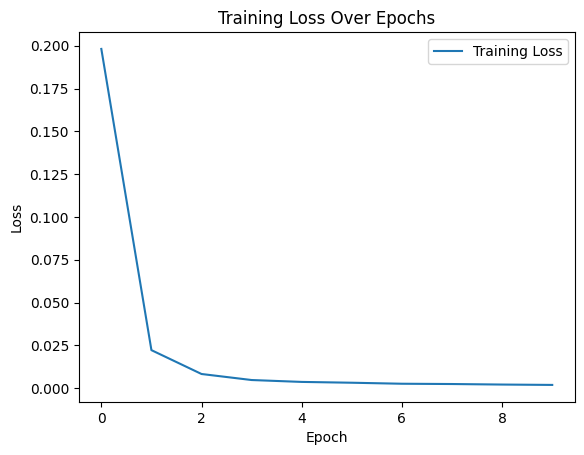

In [5]:
model = PytorchModel(CnnRul())
model.end2end_train(train_set, 10, weight_decay=0.01)
Plotter.loss(model)

# 做出预测

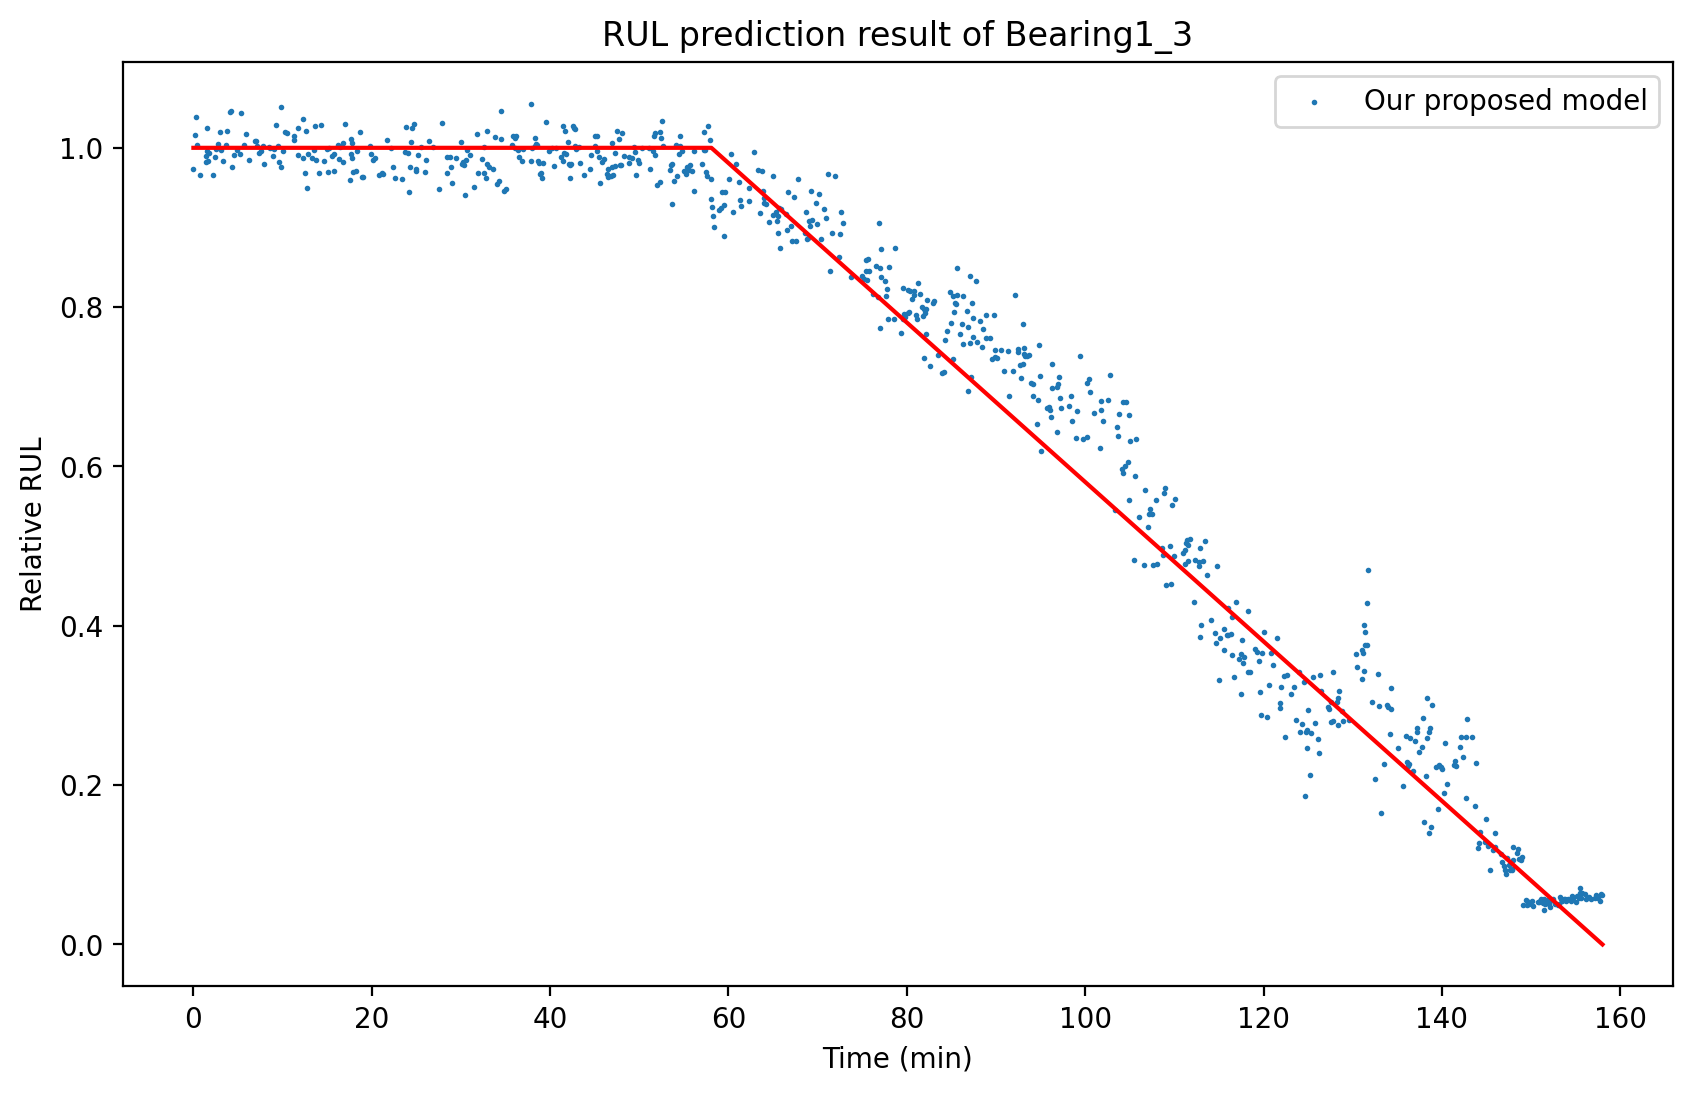

In [6]:
result = model.end2end_predict(test_set)
Plotter.end2end_rul(test_set, result)

# 预测结果评价

In [7]:
evaluator = End2EndEvaluator()
evaluator.add_metric(End2EndMAE(), End2EndMSE(), End2EndRMSE())
evaluator.evaluate(test_set, result)


INFO - 17:08:52 >> 
轴承Bearing1_3的预测结果评价：
  MAE： 0.0366
  MSE： 0.0024
  RMSE： 0.0489
